In [231]:
from re import sub
from decimal import Decimal

In [1]:
import pandas as pd

def import_MTA_Turnstile_Data(Int_start_month, Int_end_month):
    df =[]
    for m in range(Int_start_month, Int_end_month):
        for d in range(1,31):
            url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_19' + ('%02d') % (m,) + ('%02d') % (d,) + '.txt' 
            print('Reading file :'+ ' '+ url)
            try:
                tempDF = pd.read_csv(url)
                print('Complete')
                if len(df) < 1:
                    df = tempDF 
                else:
                    df = pd.concat([df,tempDF])
            except Exception:
                pass
    return(df)

turnstile_df = import_MTA_Turnstile_Data(2,5)

Reading file : http://web.mta.info/developers/data/nyct/turnstile/turnstile_190201.txt
Reading file : http://web.mta.info/developers/data/nyct/turnstile/turnstile_190202.txt
Complete
Reading file : http://web.mta.info/developers/data/nyct/turnstile/turnstile_190203.txt
Reading file : http://web.mta.info/developers/data/nyct/turnstile/turnstile_190204.txt
Reading file : http://web.mta.info/developers/data/nyct/turnstile/turnstile_190205.txt
Reading file : http://web.mta.info/developers/data/nyct/turnstile/turnstile_190206.txt
Reading file : http://web.mta.info/developers/data/nyct/turnstile/turnstile_190207.txt
Reading file : http://web.mta.info/developers/data/nyct/turnstile/turnstile_190208.txt
Reading file : http://web.mta.info/developers/data/nyct/turnstile/turnstile_190209.txt
Complete
Reading file : http://web.mta.info/developers/data/nyct/turnstile/turnstile_190210.txt
Reading file : http://web.mta.info/developers/data/nyct/turnstile/turnstile_190211.txt
Reading file : http://web

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime as dt
import seaborn as sns
import pandas as pd
import urllib
import json

Concatinating Stations and Lines:

In [3]:
turnstile_df['STATION'] = turnstile_df['STATION'] + "_"+ turnstile_df['LINENAME']

In [4]:
turnstile_df.DATE.unique()

array(['01/26/2019', '01/27/2019', '01/28/2019', '01/29/2019',
       '01/30/2019', '01/31/2019', '02/01/2019', '02/02/2019',
       '02/03/2019', '02/04/2019', '02/05/2019', '02/06/2019',
       '02/07/2019', '02/08/2019', '02/09/2019', '02/10/2019',
       '02/11/2019', '02/12/2019', '02/13/2019', '02/14/2019',
       '02/15/2019', '02/16/2019', '02/17/2019', '02/18/2019',
       '02/19/2019', '02/20/2019', '02/21/2019', '02/22/2019',
       '02/23/2019', '02/24/2019', '02/25/2019', '02/26/2019',
       '02/27/2019', '02/28/2019', '03/01/2019', '03/02/2019',
       '03/03/2019', '03/04/2019', '03/05/2019', '03/06/2019',
       '03/07/2019', '03/08/2019', '03/09/2019', '03/10/2019',
       '03/11/2019', '03/12/2019', '03/13/2019', '03/14/2019',
       '03/15/2019', '03/16/2019', '03/17/2019', '03/18/2019',
       '03/19/2019', '03/20/2019', '03/21/2019', '03/22/2019',
       '03/23/2019', '03/24/2019', '03/25/2019', '03/26/2019',
       '03/27/2019', '03/28/2019', '03/29/2019', '03/30

In [5]:
turnstile_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST_NQR456W,NQR456W,BMT,01/26/2019,03:00:00,REGULAR,6922652,2347673
1,A002,R051,02-00-00,59 ST_NQR456W,NQR456W,BMT,01/26/2019,07:00:00,REGULAR,6922669,2347688
2,A002,R051,02-00-00,59 ST_NQR456W,NQR456W,BMT,01/26/2019,11:00:00,REGULAR,6922747,2347773
3,A002,R051,02-00-00,59 ST_NQR456W,NQR456W,BMT,01/26/2019,15:00:00,RECOVR AUD,6922932,2347849
4,A002,R051,02-00-00,59 ST_NQR456W,NQR456W,BMT,01/26/2019,19:00:00,REGULAR,6923237,2347911


In [6]:
turnstile_df.columns = [i.strip() for i in turnstile_df.columns]

In [7]:
turnstile_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

Creating Datetime column:

In [8]:

turnstile_df['dateTime'] = pd.to_datetime(turnstile_df.DATE +' '+ turnstile_df.TIME, format='%m/%d/%Y %H:%M:%S')
turnstile_df.head(1)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,dateTime
0,A002,R051,02-00-00,59 ST_NQR456W,NQR456W,BMT,01/26/2019,03:00:00,REGULAR,6922652,2347673,2019-01-26 03:00:00


Calculating the difference between entries/exits from the previous date to get incremental entries and exits, grouping by turnstile: 

In [9]:
key = ['C/A',
'UNIT',
'SCP',
'STATION']

def getDiff(turnstile_df):
    turnstile_df = turnstile_df.sort_values('dateTime')
    turnstile_df['Incr_ENTRIES'] =  turnstile_df.ENTRIES - turnstile_df.ENTRIES.shift(1)
    turnstile_df['Incr_EXITS'] = turnstile_df.EXITS - turnstile_df.EXITS.shift(1)
    return(turnstile_df)


newDF = turnstile_df.groupby(key, as_index=False).apply(lambda x: getDiff(x)).reset_index()

In [10]:
newDF = newDF[list(turnstile_df.columns.values) + ['Incr_ENTRIES', 'Incr_EXITS']]
newDF.head(4)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,dateTime,Incr_ENTRIES,Incr_EXITS
0,A002,R051,02-00-00,59 ST_NQR456W,NQR456W,BMT,01/26/2019,03:00:00,REGULAR,6922652,2347673,2019-01-26 03:00:00,NaN,NaN
1,A002,R051,02-00-00,59 ST_NQR456W,NQR456W,BMT,01/26/2019,07:00:00,REGULAR,6922669,2347688,2019-01-26 07:00:00,17.0,15.0
2,A002,R051,02-00-00,59 ST_NQR456W,NQR456W,BMT,01/26/2019,11:00:00,REGULAR,6922747,2347773,2019-01-26 11:00:00,78.0,85.0
3,A002,R051,02-00-00,59 ST_NQR456W,NQR456W,BMT,01/26/2019,15:00:00,RECOVR AUD,6922932,2347849,2019-01-26 15:00:00,185.0,76.0


Adjusting for Outliers: 

In [11]:
newDF.DESC.value_counts()

REGULAR       2631802
RECOVR AUD      13001
Name: DESC, dtype: int64

Deleting audit values:

In [12]:
newDF = newDF[newDF.DESC != 'RECOVR AUD']

Getting rid of outliers by removing negative incremental entries and exits: 

In [13]:
newDF = newDF.loc[(newDF['Incr_ENTRIES']>0) & (newDF['Incr_EXITS']>0),]

In [14]:
(newDF['Incr_ENTRIES']<0).sample(3)

1205805    False
815510     False
1777695    False
Name: Incr_ENTRIES, dtype: bool

In [15]:
newDF['Incr_ENTRIES'].describe()

count    2.135612e+06
mean     8.941246e+03
std      3.335233e+06
min      1.000000e+00
25%      3.000000e+01
50%      1.100000e+02
75%      2.780000e+02
max      2.088503e+09
Name: Incr_ENTRIES, dtype: float64

In [25]:
newDF.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,dateTime,Incr_ENTRIES,Incr_EXITS,totalFootTraffic
1,A002,R051,02-00-00,59 ST_NQR456W,NQR456W,BMT,01/26/2019,07:00:00,REGULAR,6922669,2347688,2019-01-26 07:00:00,17.0,15.0,32.0
2,A002,R051,02-00-00,59 ST_NQR456W,NQR456W,BMT,01/26/2019,11:00:00,REGULAR,6922747,2347773,2019-01-26 11:00:00,78.0,85.0,163.0
4,A002,R051,02-00-00,59 ST_NQR456W,NQR456W,BMT,01/26/2019,19:00:00,REGULAR,6923237,2347911,2019-01-26 19:00:00,305.0,62.0,367.0
5,A002,R051,02-00-00,59 ST_NQR456W,NQR456W,BMT,01/26/2019,23:00:00,REGULAR,6923412,2347939,2019-01-26 23:00:00,175.0,28.0,203.0
6,A002,R051,02-00-00,59 ST_NQR456W,NQR456W,BMT,01/27/2019,03:00:00,REGULAR,6923456,2347944,2019-01-27 03:00:00,44.0,5.0,49.0


Filling null values in 'total traffic' with mean for that column:

In [29]:
newDF['totalFootTraffic'] = newDF['Incr_ENTRIES'] + newDF['Incr_EXITS']

In [31]:
newDF['totalFootTraffic']= newDF.totalFootTraffic.fillna(newDF.totalFootTraffic.mean())
newDF.sample(4)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,dateTime,Incr_ENTRIES,Incr_EXITS,totalFootTraffic
1051291,N319,R298,01-06-01,NORTHERN BLVD_MR,MR,IND,02/03/2019,16:00:00,REGULAR,662366,5179,2019-02-03 16:00:00,23.0,10.0,33.0
1621016,PTH22,R540,00-01-03,PATH NEW WTC_1,1,PTH,04/17/2019,08:47:27,REGULAR,202754,212948,2019-04-17 08:47:27,177.0,942.0,1119.0
2236576,R321,R386,01-00-02,174 ST_25,25,IRT,04/02/2019,05:00:00,REGULAR,1653499,5483736,2019-04-02 05:00:00,3.0,40.0,43.0
2292402,R412,R146,00-03-01,HUNTS POINT AV_6,6,IRT,03/26/2019,09:00:00,REGULAR,2129091,3065569,2019-03-26 09:00:00,419.0,243.0,662.0


In [30]:
newDF.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'dateTime', 'Incr_ENTRIES', 'Incr_EXITS',
       'totalFootTraffic'],
      dtype='object')

In [32]:
key = ['C/A',
'UNIT',
'SCP',
'STATION']

newDF.groupby(['STATION']).totalFootTraffic.agg(['median']).sort_values('median', ascending=False).head(20)

#(['STATION','totalFootTraffic', 'dateTime'])
#newDF=newDF.groupby(['STATION','totalFootTraffic', 'dateTime']).totalFootTraffic.agg(['median']).sort_values('median', ascending=False).head(20)
#newDF.groupby(key, as_index=False).totalFootTraffic.agg(['sum']).sort_values('sum', ascending=False).reset_index()
#newDF.groupby(key, as_index=False).totalFootTraffic.agg(['sum']).sort_values('sum', ascending=False).reset_index()

,median
STATION,
BAY PKWY_N,811.5
GRAND ST_BD,807.0
14 ST-UNION SQ_456LNQRW,800.0
181 ST_1,705.0
145 ST_ABCD,694.0
7 AV_BQ,690.5
MYRTLE AV_JMZ,656.0
72 ST_123,648.0
BEDFORD AV_L,644.5


In [33]:
newDF.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'dateTime', 'Incr_ENTRIES', 'Incr_EXITS',
       'totalFootTraffic'],
      dtype='object')

In [85]:
newDF2 = newDF.iloc[: , [3, 11, 14]].copy()      #new = old.iloc[: , [1, 6, 7]].copy() 

In [86]:
newDF2.head(3)

,STATION,dateTime,totalFootTraffic
1,59 ST_NQR456W,2019-01-26 07:00:00,32.0
2,59 ST_NQR456W,2019-01-26 11:00:00,163.0
4,59 ST_NQR456W,2019-01-26 19:00:00,367.0


In [100]:
# Group by station
top_stations_by_traffic = newDF2.groupby('STATION').median()
top_stations_by_traffic.reset_index(inplace=True)

# Sort by totalFootTraffic
top_stations_by_traffic.sort_values(by='totalFootTraffic', ascending=False, inplace=True)
#df_by_spec_count = df.groupby('Speciality')['Amount'].agg(['mean', 'count'])

In [101]:
top_stations_by_traffic.head(10)

,STATION,totalFootTraffic
193,BAY PKWY_N,811.5
308,GRAND ST_BD,807.0
23,14 ST-UNION SQ_456LNQRW,800.0
55,181 ST_1,705.0
30,145 ST_ABCD,694.0
135,7 AV_BQ,690.5
374,MYRTLE AV_JMZ,656.0
139,72 ST_123,648.0
205,BEDFORD AV_L,644.5
475,YORK ST_F,643.0


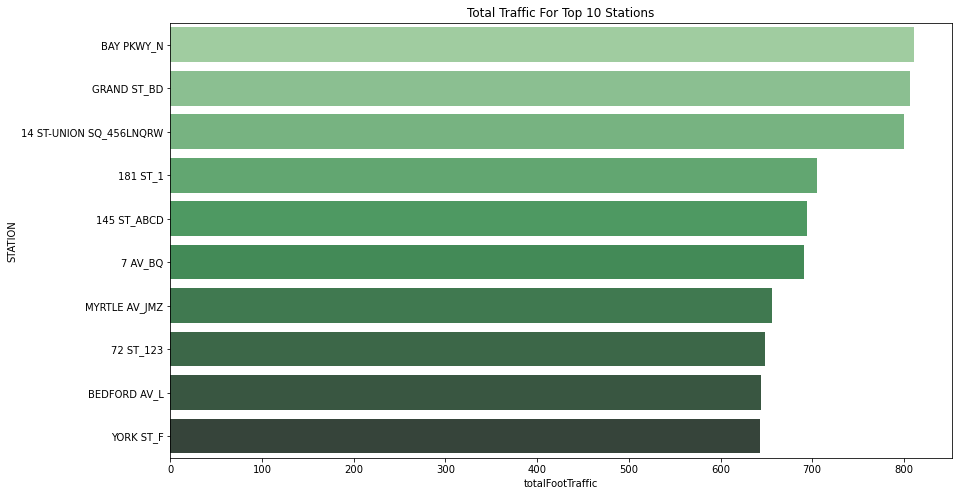

In [103]:
# Create horizontal bar plot of the top 10 stations
plt.figure(figsize = (14, 8))
plt.title("Total Traffic For Top 10 Stations")

# Select top ten only
top_ten_stations = top_stations_by_traffic.head(10)

# Define the parameters of bar plot
sns.barplot(x="totalFootTraffic", 
            y="STATION", 
            orient="h", 
            data=top_ten_stations, 
            palette="Greens_d")
plt.savefig('10TopStations.png', dpi = 1000)

# Cleaning up Station Names

In [141]:
# We need to remove the _TrainNumber from the Station in top_stations_by_traffic

In [142]:
# Create a new DF to store clean version of stations
clean_top_stations_by_traffic = top_stations_by_traffic

In [149]:
# This function splits the station names by "_" character, and takes the values 
# before the underscore

clean_top_stations_by_traffic['STATION'] = clean_top_stations_by_traffic['STATION'].apply(lambda x: str(x).split('_')[0])


In [150]:
clean_top_stations_by_traffic.head(10)

,STATION,totalFootTraffic
193,BAY PKWY,811.5
308,GRAND ST,807.0
23,14 ST-UNION SQ,800.0
55,181 ST,705.0
30,145 ST,694.0
135,7 AV,690.5
374,MYRTLE AV,656.0
139,72 ST,648.0
205,BEDFORD AV,644.5
475,YORK ST,643.0


# Join with Zip Codes

In [112]:
# Load Station File
stations_zip = pd.read_csv('stations_zip.csv')

# Retain only station and zip code columns
station_zip_map = stations_zip[['STATION', 'ZIP']]
station_zip_map.head(3)

#Dropping duplicates:
station_zip_map.drop_duplicates(inplace=True)
station_zip_map.head(10)

<ipython-input-112-0ac0d6ef0408>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_zip_map.drop_duplicates(inplace=True)


,STATION,ZIP
0,59 ST,10155.0
478,5 AV/59 ST,10153.0
1052,57 ST-7 AV,10106.0
1872,49 ST,10153.0
1873,49 ST,10020.0
3712,TIMES SQ-42 ST,10036.0
4040,34 ST-HERALD SQ,10098.0
4655,28 ST,10098.0
5024,23 ST,10098.0
5598,14 ST-UNION SQ,10003.0


# Join station_zip_map with top_stations_by_traffic

In [152]:
station_zip_traffic = station_zip_map.set_index('STATION').join(clean_top_stations_by_traffic.set_index('STATION'), how='inner')


In [175]:
# Check to see if any null values are in the top 15 stations
station_zip_traffic.sort_values(by='totalFootTraffic', ascending=False, inplace=True)

station_zip_traffic.head(15)
# There are none

,ZIP,totalFootTraffic
STATION,,
BAY PKWY,11286.0,811.5
GRAND ST,10009.0,807.0
GRAND ST,10002.0,807.0
14 ST-UNION SQ,10003.0,800.0
181 ST,10033.0,705.0
145 ST,10039.0,694.0
145 ST,10031.0,694.0
7 AV,11517.0,690.5
7 AV,10104.0,690.5


In [178]:
# Drop rows with null values for zipcode
station_zip_traffic.dropna(inplace=True)

# Reset Index
station_zip_traffic.reset_index(inplace=True)

station_zip_traffic.head(2)

,STATION,ZIP,totalFootTraffic
0,BAY PKWY,11286.0,811.5
1,GRAND ST,10009.0,807.0


# Join station_zip_traffic with demographic data

In [188]:
demograph_df = pd.read_csv('NYC ZIP CODES_ Population and Household income - Sheet1.csv')

In [189]:
demograph_df.head(2)

,Unnamed: 0,Zip Code,Location,City,Population,Average household income,National Rank
0,1,10577,"41.041731, -73.709727","Purchase, New York","3,454","$183,686.00",#4
1,2,10514,"41.172330, -73.768948","Chappaqua, New York","12,004","$173,368.00",#6


In [190]:
# First, we need to make the zip columns consistently named
demograph_df.rename(columns={'Zip Code': 'ZIP'}, inplace=True)

demograph_df.columns

Index(['Unnamed: 0', 'ZIP', 'Location', 'City ', 'Population ',
       'Average household income', 'National Rank '],
      dtype='object')

In [191]:
# Next, we need to make the zip columns a consistent type (integer)
# by changing the station_zip_traffic ZIP column to int from float
station_zip_traffic['ZIP'] = station_zip_traffic['ZIP'].astype(int)  


In [192]:
station_zip_traffic.head(2)

,STATION,ZIP,totalFootTraffic
0,BAY PKWY,11286,811.5
1,GRAND ST,10009,807.0


In [201]:
station_zip_traffic.drop_duplicates(subset='STATION').count()

STATION             358
ZIP                 358
totalFootTraffic    358
dtype: int64

In [195]:
# Drop dupicates from demographic data
demograph_df.drop_duplicates(subset='ZIP', inplace=True)

In [204]:
# Drop duplicates form station_zip_traffic
station_zip_traffic.drop_duplicates(subset='STATION', inplace=True)

In [215]:
#Join station_zip_traffic with demograph_df data:

station_demograph = station_zip_traffic.set_index('ZIP').join(demograph_df.set_index('ZIP'), how='left')
station_demograph.head(3)



,STATION,totalFootTraffic,Unnamed: 0,Location,City,Population,Average household income,National Rank
ZIP,,,,,,,,
10002,YORK ST,643.0,"1,529.00","40.715952, -73.985870","New York, New York","84,870","$24,022.00","#28,798"
10002,2 AV,375.0,"1,529.00","40.715952, -73.985870","New York, New York","84,870","$24,022.00","#28,798"
10002,DELANCEY/ESSEX,303.0,"1,529.00","40.715952, -73.985870","New York, New York","84,870","$24,022.00","#28,798"


In [219]:
station_demograph.sort_values(by='totalFootTraffic' , inplace=True, ascending=False) 

In [221]:
station_demograph.head(15)

,STATION,totalFootTraffic,Unnamed: 0,Location,City,Population,Average household income,National Rank
ZIP,,,,,,,,
11286,BAY PKWY,811.5,NaN,NaN,NaN,NaN,NaN,NaN
10009,GRAND ST,807.0,845,"40.726622, -73.978955","New York, New York","58,595","$40,176.00","#11,980"
10003,14 ST-UNION SQ,800.0,271,"40.731856, -73.989145","New York, New York","53,673","$60,891.00","#2,796"
10033,181 ST,705.0,"1,371.00","40.849124, -73.935956","New York, New York","58,259","$31,348.00","#21,836"
10039,145 ST,694.0,"1,574.00","40.826296, -73.937053","New York, New York","21,737","$17,370.00","#31,063"
11517,7 AV,690.5,NaN,NaN,NaN,NaN,NaN,NaN
10009,MYRTLE AV,656.0,845,"40.726622, -73.978955","New York, New York","58,595","$40,176.00","#11,980"
10023,72 ST,648.0,141,"40.775394, -73.982197","New York, New York","62,206","$72,424.00","#1,297"
10009,BEDFORD AV,644.5,845,"40.726622, -73.978955","New York, New York","58,595","$40,176.00","#11,980"


In [222]:
#DROP NULLS BECAUSE OF TIME CONSTRAINT:

station_demograph.dropna(inplace=True)

In [224]:
station_demograph.head(10)

,STATION,totalFootTraffic,Unnamed: 0,Location,City,Population,Average household income,National Rank
ZIP,,,,,,,,
10009,GRAND ST,807.0,845,"40.726622, -73.978955","New York, New York","58,595","$40,176.00","#11,980"
10003,14 ST-UNION SQ,800.0,271,"40.731856, -73.989145","New York, New York","53,673","$60,891.00","#2,796"
10033,181 ST,705.0,"1,371.00","40.849124, -73.935956","New York, New York","58,259","$31,348.00","#21,836"
10039,145 ST,694.0,"1,574.00","40.826296, -73.937053","New York, New York","21,737","$17,370.00","#31,063"
10009,MYRTLE AV,656.0,845,"40.726622, -73.978955","New York, New York","58,595","$40,176.00","#11,980"
10023,72 ST,648.0,141,"40.775394, -73.982197","New York, New York","62,206","$72,424.00","#1,297"
10009,BEDFORD AV,644.5,845,"40.726622, -73.978955","New York, New York","58,595","$40,176.00","#11,980"
10002,YORK ST,643.0,"1,529.00","40.715952, -73.985870","New York, New York","84,870","$24,022.00","#28,798"
10040,191 ST,633.0,"1,485.00","40.858134, -73.929031","New York, New York","46,599","$27,905.00","#25,782"


# TOP TEN STATIONS WITH CORRESPONDING DEMOGRAPHIC DATA:

In [228]:
# reset index
station_demograph.reset_index(inplace=True)

station_demograph.head(10)

,ZIP,STATION,totalFootTraffic,Unnamed: 0,Location,City,Population,Average household income,National Rank
0,10009,GRAND ST,807.0,845,"40.726622, -73.978955","New York, New York","58,595","$40,176.00","#11,980"
1,10003,14 ST-UNION SQ,800.0,271,"40.731856, -73.989145","New York, New York","53,673","$60,891.00","#2,796"
2,10033,181 ST,705.0,"1,371.00","40.849124, -73.935956","New York, New York","58,259","$31,348.00","#21,836"
3,10039,145 ST,694.0,"1,574.00","40.826296, -73.937053","New York, New York","21,737","$17,370.00","#31,063"
4,10009,MYRTLE AV,656.0,845,"40.726622, -73.978955","New York, New York","58,595","$40,176.00","#11,980"
5,10023,72 ST,648.0,141,"40.775394, -73.982197","New York, New York","62,206","$72,424.00","#1,297"
6,10009,BEDFORD AV,644.5,845,"40.726622, -73.978955","New York, New York","58,595","$40,176.00","#11,980"
7,10002,YORK ST,643.0,"1,529.00","40.715952, -73.985870","New York, New York","84,870","$24,022.00","#28,798"
8,10040,191 ST,633.0,"1,485.00","40.858134, -73.929031","New York, New York","46,599","$27,905.00","#25,782"
9,10035,ASTORIA DITMARS,619.0,"1,582.00","40.795487, -73.929501","New York, New York","32,702","$14,896.00","#31,403"


# Income distribution: 

In [243]:
# First, convert the Income column to a float
station_demograph['Average Income Float'] = station_demograph['Average household income'].apply(lambda x: Decimal(sub(r'[^\d.]', '', x)))

# Next create the income brackets

station_demograph['Average Income Bracket'] = station_demograph['Average Income Float'].apply(lambda x: 'Below 60K' if x < 60000 else '60K+')

In [245]:
station_demograph.groupby('Average Income Bracket').count()

,ZIP,STATION,totalFootTraffic,Unnamed: 0,Location,City,Population,Average household income,National Rank,Average Income Float
Average Income Bracket,,,,,,,,,,
60K+,26,26,26,26,26,26,26,26,26,26
Below 60K,147,147,147,147,147,147,147,147,147,147


In [247]:
station_demograph.head(10)

,ZIP,STATION,totalFootTraffic,Unnamed: 0,Location,City,Population,Average household income,National Rank,Average Income Bracket,Average Income Float
0,10009,GRAND ST,807.0,845,"40.726622, -73.978955","New York, New York","58,595","$40,176.00","#11,980",Below 60K,40176.00
1,10003,14 ST-UNION SQ,800.0,271,"40.731856, -73.989145","New York, New York","53,673","$60,891.00","#2,796",60K+,60891.00
2,10033,181 ST,705.0,"1,371.00","40.849124, -73.935956","New York, New York","58,259","$31,348.00","#21,836",Below 60K,31348.00
3,10039,145 ST,694.0,"1,574.00","40.826296, -73.937053","New York, New York","21,737","$17,370.00","#31,063",Below 60K,17370.00
4,10009,MYRTLE AV,656.0,845,"40.726622, -73.978955","New York, New York","58,595","$40,176.00","#11,980",Below 60K,40176.00
5,10023,72 ST,648.0,141,"40.775394, -73.982197","New York, New York","62,206","$72,424.00","#1,297",60K+,72424.00
6,10009,BEDFORD AV,644.5,845,"40.726622, -73.978955","New York, New York","58,595","$40,176.00","#11,980",Below 60K,40176.00
7,10002,YORK ST,643.0,"1,529.00","40.715952, -73.985870","New York, New York","84,870","$24,022.00","#28,798",Below 60K,24022.00
8,10040,191 ST,633.0,"1,485.00","40.858134, -73.929031","New York, New York","46,599","$27,905.00","#25,782",Below 60K,27905.00
9,10035,ASTORIA DITMARS,619.0,"1,582.00","40.795487, -73.929501","New York, New York","32,702","$14,896.00","#31,403",Below 60K,14896.00


In [ ]:
# Let's graph this now

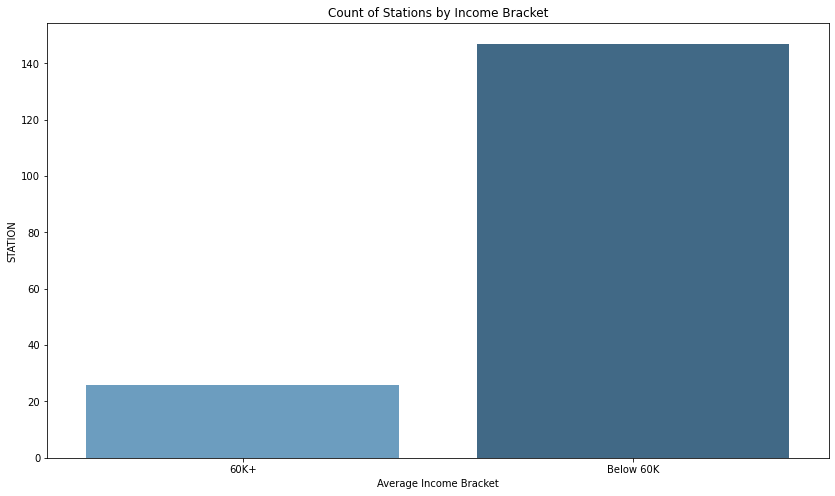

In [254]:
# Create bar plot of the number of stations by income bracket
plt.figure(figsize = (14, 8))
plt.title("Count of Stations by Income Bracket")

# Group by Income Bracket
income_bracket_grouped = station_demograph.groupby('Average Income Bracket').count()
income_bracket_grouped.reset_index(inplace=True)

# Define the parameters of bar plot
sns.barplot(x="Average Income Bracket", 
            y="STATION", 
            data=income_bracket_grouped, 
            palette="Blues_d")


plt.savefig('StationsByIncomeBracket.png', dpi = 1000)

# Top Stations with >60K Income

In [255]:
station_demograph_60plus = station_demograph[station_demograph['Average Income Bracket'] == '60K+']

In [258]:
station_demograph_60plus.head(5)

,ZIP,STATION,totalFootTraffic,Unnamed: 0,Location,City,Population,Average household income,National Rank,Average Income Bracket,Average Income Float
1,10003,14 ST-UNION SQ,800.0,271,"40.731856, -73.989145","New York, New York","53,673","$60,891.00","#2,796",60K+,60891.00
5,10023,72 ST,648.0,141,"40.775394, -73.982197","New York, New York","62,206","$72,424.00","#1,297",60K+,72424.00
22,10014,W 4 ST-WASH SQ,516.0,205,"40.733471, -74.007098","New York, New York","32,667","$66,601.00","#1,931",60K+,66601.00
25,10011,8 AV,489.0,260,"40.741844, -74.000711","New York, New York","46,669","$61,986.00","#2,569",60K+,61986.00
29,10162,30 AV,467.0,30,"40.769298, -73.949942","New York, New York","1,726","$108,416.00",#158,60K+,108416.00


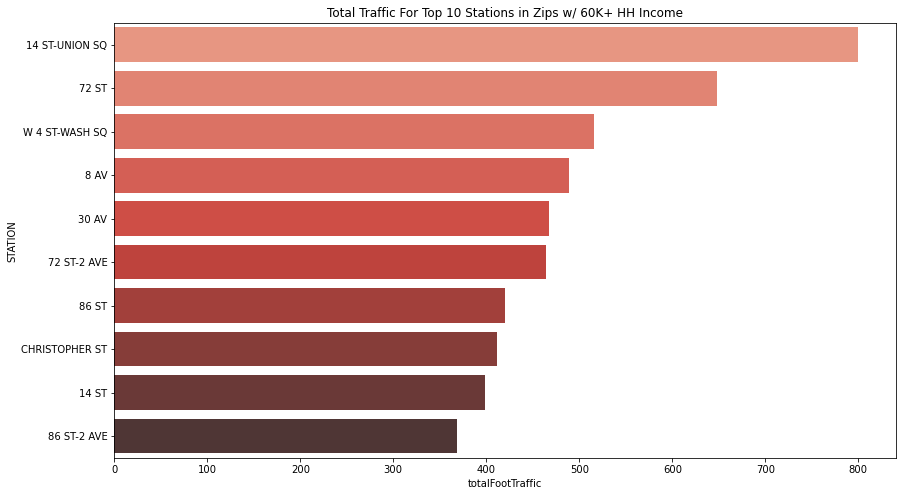

In [259]:
# Create horizontal bar plot of the top 10 stations that are above 60K income
plt.figure(figsize = (14, 8))
plt.title("Total Traffic For Top 10 Stations in Zips w/ 60K+ HH Income")

# Select top ten only
top_ten_stations = station_demograph_60plus.head(10)

# Define the parameters of bar plot
sns.barplot(x="totalFootTraffic", 
            y="STATION", 
            orient="h", 
            data=top_ten_stations, 
            palette="Reds_d")
plt.savefig('10TopStations60KPlus.png', dpi = 1000)